# Библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt

# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 
- минута разговора: 3 рубля 
- сообщение: 3 рубля 
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 
- минута разговора: 1 рубль 
- сообщение: 1 рубль 
- 1 Гб интернет-трафика: 150 рублей 

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

# Описание данных

**Таблица users (информация о пользователях):**

user_id — уникальный идентификатор пользователя  
nfirst_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

**Таблица calls (информация о звонках):**

id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  

**Таблица messages (информация о сообщениях):**

id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**

id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  

**Таблица tariffs (информация о тарифах):**

tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  


*Примечание. Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupyter Notebook.*

# Шаг 1. Открытие и изучение файлов 

>**Откройте файл с данными и изучите общую информацию.**

In [2]:
users = pd.read_csv('users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
users['tariff'].value_counts()
# Большая часть пользователей имеет тариф smart

smart    351
ultra    149
Name: tariff, dtype: int64

In [4]:
users['city'].value_counts()
# Основные пользователи проживают в городах Москва, Санкт-Петербург

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Нижневартовск       1
Архангельск         1
Химки               1
Подольск            1
Иваново             1
Name: city, Length: 76, dtype: int64

In [5]:
calls = pd.read_csv('calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
messages = pd.read_csv('messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
internet = pd.read_csv('internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [8]:
tariffs = pd.read_csv('tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


##### Посмотрим на информацию о каждом датасете

In [9]:
users.info()
# reg_date  - имеет тип object. Нужно будет изменить на дату

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
calls.info()
# call_date - - имеет тип object. Нужно будет изменить на дату

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [11]:
messages.info()
# message_date - имеет тип object. Нужно будет изменить на дату

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [12]:
internet.info()
# session_date  - имеет тип object. Нужно будет изменить на дату
# Колонку unnamed:0 можно удалить

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [14]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


In [15]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [16]:
messages.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


In [17]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [18]:
tariffs.describe().T

,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0


**Вывод**:

    - Есть колонки с несоответсвующими типами. Необходимы типы изменить  
    - Пустые значени есть только в колонке churn_date, но это объяняется в описании датасета. Заполнять или удалять значения в данной колонке не требуется  
    - Имеются колонки, по которым в дальнейшем возможно осуществить join  
    - Есть колонки в которых длительность звонка = 0.0 мин. Необходимо оценить что делать с ними в дальнейшем.

# Шаг 2. Подготовьте данные

> - Приведите данные к нужным типам;
> - Найдите и исправьте ошибки в данных.

*Поясните, какие ошибки вы нашли и как их исправили. Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.*

Посчитайте для каждого пользователя:

> - количество сделанных звонков и израсходованных минут разговора по месяцам;
> - количество отправленных сообщений по месяцам;
> - объем израсходованного интернет-трафика по месяцам;
> - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
> - остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [19]:
# Изменим типы данных и удалим ненужную колонку

In [20]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [21]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [22]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [23]:
internet = internet.drop('Unnamed: 0', axis=1)

In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [25]:
# Посмотрим на нулвую продолжительность звонков в датасете calls

In [26]:
calls['duration'].value_counts()
# Много нулевых значений

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

In [27]:
len(calls.query('duration == 0')) / len(calls)

0.19551644316336553

### Практически 20% звонков имеют нулевую продолжительность 

In [28]:
# Округлим количество минут в большую сторону, т.к оператор делает также. Проверим получившиеся данные
calls['duration'] = calls['duration'].apply(np.ceil)

In [29]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


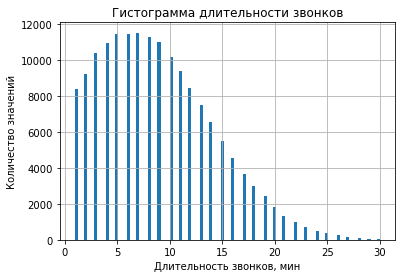

In [30]:
ax = calls['duration'].hist(bins=100, range=(1, 30))
ax.set_title("Гистограмма длительности звонков")
ax.set_xlabel("Длительность звонков, мин")
ax.set_ylabel("Количество значений")
plt.show()

### Пик приходится на 5-8 мин. Пользователи редко разговариевают более 25 мин

In [31]:
calls['duration'].describe()
# В среднем звонок длится около 7 мин

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

### Округлим также значения по потребленному количеству мегабайт.

In [32]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [33]:
internet['mb_used'].value_counts()

0.0       19598
333.0       231
382.0       228
377.0       224
253.0       222
          ...  
1308.0        1
1456.0        1
1375.0        1
1364.0        1
1291.0        1
Name: mb_used, Length: 1424, dtype: int64

### В большинстве пользователи интернета расходуют трафик в диапазоне 250-500 мегабайт. Это достаточно высокий показатель, т.к оценка произволдится за сессию. Больше гигабайта интернета расходуют небольшое количество пользователей

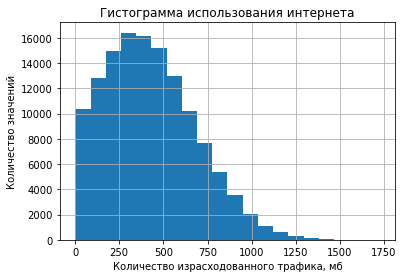

In [34]:
ax = internet['mb_used'].hist(bins=20, range=(1, max(internet['mb_used'])))
ax.set_title("Гистограмма использования интернета")
ax.set_xlabel("Количество израсходованного трафика, мб")
ax.set_ylabel("Количество значений")
plt.show()

## Посчитайте для каждого пользователя:

### количество сделанных звонков и израсходованных минут разговора по месяцам;

In [35]:
# Для выполнению расчетов сделаем отдельную колонку, в которой отразим месяц
calls['month'] = calls['call_date'].dt.month

In [36]:
users['month'] = users['reg_date'].dt.month
users.rename(columns={'month': 'month_of_registration'}, inplace=True)

In [37]:
calls_pivot = (
    calls
        .pivot_table(index=['user_id', 'month'], 
                     values='duration', 
                     aggfunc = ['count', 'sum'])
        .reset_index()
)

calls_pivot.columns = ['user_id', 'month', 'calls_by_month', 'minute_calls_by_month']
calls_pivot

,user_id,month,calls_by_month,minute_calls_by_month
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
...,...,...,...,...
3169,1498,10,41,247.0
3170,1499,9,9,70.0
3171,1499,10,68,449.0
3172,1499,11,74,612.0


### количество отправленных сообщений по месяцам;

In [38]:
# Создадим колонку с месяцем в messages
messages['month'] = messages['message_date'].dt.month

In [39]:
messages_pivot = (
    messages
        .pivot_table(index=['user_id', 'month'], 
                     values='id',
                     aggfunc = 'count')
        .reset_index()
        .rename(columns={'id':'messages_by_month'})
)
messages_pivot

,user_id,month,messages_by_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### объем израсходованного интернет-трафика по месяцам;

In [40]:
internet

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000
...,...,...,...,...
149391,1499_152,319.0,2018-10-03,1499
149392,1499_153,491.0,2018-12-14,1499
149393,1499_154,0.0,2018-10-27,1499
149394,1499_155,1247.0,2018-11-26,1499


In [41]:
# Создадим колонку с месяцем в internet
internet['month'] = internet['session_date'].dt.month

In [42]:
internet_pivot = (
    internet
        .pivot_table(index= ['user_id', 'month'],
                    values = 'mb_used',
                    aggfunc = 'sum')
        .reset_index()
        .rename(columns={'mb_used': 'mb_used_by_month'})
)
internet_pivot

,user_id,month,mb_used_by_month
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3198,1498,10,20604.0
3199,1499,9,1848.0
3200,1499,10,17809.0
3201,1499,11,17984.0


### помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;

In [43]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [44]:
# Переименовывает колонку с названием тарифа для дальнейшого слияния с другой таблицей
users.rename(columns={'tariff': 'tariff_name'}, inplace=True)

In [45]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month_of_registration
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5
...,...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,8
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,1
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,10
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7


In [46]:
# Объединим полученные датафреймы
new_data = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
new_data

,user_id,month,calls_by_month,minute_calls_by_month,messages_by_month
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0
...,...,...,...,...,...
3208,1489,8,NaN,NaN,17.0
3209,1489,9,NaN,NaN,32.0
3210,1489,10,NaN,NaN,21.0
3211,1489,11,NaN,NaN,20.0


In [47]:
new_data = new_data.merge(internet_pivot, on=['user_id', 'month'], how='outer')
# new_data

In [48]:
new_data = new_data.merge(users, on='user_id', how='left')
new_data

,user_id,month,calls_by_month,minute_calls_by_month,messages_by_month,mb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month_of_registration
0,1000,5,22.0,159.0,22.0,2256.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6,43.0,172.0,60.0,23257.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7,47.0,340.0,75.0,14016.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8,52.0,408.0,81.0,14070.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9,58.0,466.0,57.0,14581.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17232.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3210,1489,10,NaN,NaN,21.0,19588.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3211,1489,11,NaN,NaN,20.0,17516.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8
3212,1489,12,NaN,NaN,35.0,17341.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8


In [49]:
# Проверим колонки на пустые значения

new_data.isna().sum()

user_id                     0
month                       0
calls_by_month             40
minute_calls_by_month      40
messages_by_month         497
mb_used_by_month           11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff_name                 0
month_of_registration       0
dtype: int64

In [50]:
# Заполним все колонки, кроме churn_date нулевыми значениями

fillna_columns = ['calls_by_month', 'minute_calls_by_month', 'messages_by_month', 'mb_used_by_month']
for columns in fillna_columns:
    new_data[columns] = new_data[columns].fillna(0)

In [51]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   calls_by_month         3214 non-null   float64       
 3   minute_calls_by_month  3214 non-null   float64       
 4   messages_by_month      3214 non-null   float64       
 5   mb_used_by_month       3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    object        
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff_name            3214 non-null   object        
 13  mon

In [52]:
new_data.head()

,user_id,month,calls_by_month,minute_calls_by_month,messages_by_month,mb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month_of_registration
0,1000,5,22.0,159.0,22.0,2256.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6,43.0,172.0,60.0,23257.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7,47.0,340.0,75.0,14016.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8,52.0,408.0,81.0,14070.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9,58.0,466.0,57.0,14581.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5


In [53]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [54]:
# Объявим переменные, которые будем использовать в функции для расчетов
smart_mb_per_month_included = tariffs.loc[0]['mb_per_month_included']
smart_messages_included = tariffs.loc[0]['messages_included']
smart_minutes_included  = tariffs.loc[0]['minutes_included']
smart_rub_per_minute = tariffs.loc[0]['rub_per_minute']
smart_rub_per_message = tariffs.loc[0]['rub_per_message']
smart_rub_per_gb = tariffs.loc[0]['rub_per_gb']
smart_rub_monthly_fee = tariffs.loc[0]['rub_monthly_fee']

ultra_mb_per_month_included = tariffs.loc[1]['mb_per_month_included']
ultra_messages_included = tariffs.loc[1]['messages_included']
ultra_minutes_included  = tariffs.loc[1]['minutes_included']
ultra_rub_per_minute = tariffs.loc[1]['rub_per_minute']
ultra_rub_per_message = tariffs.loc[1]['rub_per_message']
ultra_rub_per_gb = tariffs.loc[1]['rub_per_gb']
ultra_rub_monthly_fee = tariffs.loc[1]['rub_monthly_fee']

In [55]:
new_data['mb_used_by_month'] - ultra_mb_per_month_included

0      -28464.0
1       -7463.0
2      -16704.0
3      -16650.0
4      -16139.0
         ...   
3209   -13488.0
3210   -11132.0
3211   -13204.0
3212   -13379.0
3213   -30189.0
Name: mb_used_by_month, Length: 3214, dtype: float64

In [56]:
# Напишем функцию расчета прибыли в зависимости от тарифа
# помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;

def profit_on_users(row):
    
    """
    Функция рассчитывает абонентскую плату пользователей
    в зависимости от их тарифа и бесплатных лимитов на пользование 
    интернетом, смс, минутами разговоров.
    
    Если количество израсходованных минут разговора, смс или интернет-трафика
    превышает лимит включенный в тариф, тогда к сумме обязательного ежемесячного платежа
    добавляется сумма сверхлимитного расхода.
    
    Сверхлимитный расход рассчитывается как: Расход за месяц минус бесплатный лимит включенный в тариф.
    Если Сверхлимитный расход > 0, умножаем его на расценку по тарифу (за минуту разговора, 1 смс, гб интернета)
    
    """
    
    profit = 0
       
    minute_calls_by_month = row['minute_calls_by_month'] 
    messages_by_month = row['messages_by_month'] 
    mb_used_by_month = row['mb_used_by_month'] 

    
    if row['tariff_name'] == 'smart':
        
        minute_remains = minute_calls_by_month - smart_minutes_included
        
        if minute_remains > 0:
            profit += minute_remains * smart_rub_per_minute
        
        messages_remains = messages_by_month - smart_messages_included
        
        if messages_remains > 0:
            profit += messages_remains * smart_rub_per_message
        
        mb_remains = mb_used_by_month - smart_mb_per_month_included
        
        if mb_remains > 0:
            profit += (mb_remains / 1024) * smart_rub_per_gb
            
        if profit > 0:
            profit += smart_rub_monthly_fee
            
        else:
            profit = smart_rub_monthly_fee
               
    elif row['tariff_name'] == 'ultra':
                  
        minute_remains = minute_calls_by_month - ultra_minutes_included
        
        if minute_remains > 0:
            profit += minute_remains * ultra_rub_per_minute
        
        messages_remains = messages_by_month - ultra_messages_included
        
        if messages_remains > 0:
            profit += messages_remains * ultra_rub_per_message
        
        mb_remains = mb_used_by_month - ultra_mb_per_month_included
        
        if mb_remains > 0:
            profit += (mb_remains / 1024) * ultra_rub_per_gb
            
        if profit > 0:
            profit += ultra_rub_monthly_fee
            
        else:
            profit = ultra_rub_monthly_fee
            
    return profit

In [57]:
new_data['profit'] = new_data.apply(profit_on_users, axis=1)

In [58]:
new_data

,user_id,month,calls_by_month,minute_calls_by_month,messages_by_month,mb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month_of_registration,profit
0,1000,5,22.0,159.0,22.0,2256.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.000000
1,1000,6,43.0,172.0,60.0,23257.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.000000
2,1000,7,47.0,340.0,75.0,14016.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.000000
3,1000,8,52.0,408.0,81.0,14070.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.000000
4,1000,9,58.0,466.0,57.0,14581.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17232.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,915.625000
3210,1489,10,0.0,0.0,21.0,19588.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,1375.781250
3211,1489,11,0.0,0.0,20.0,17516.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,971.093750
3212,1489,12,0.0,0.0,35.0,17341.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,936.914062


In [59]:
# Заменим значения с плавающей точкой на целочисленные в некоторыз колонках
columns_int = ['calls_by_month', 'minute_calls_by_month', 'messages_by_month', 'mb_used_by_month']
for columns in columns_int:
    new_data[columns] = new_data[columns].astype('int')

## Вывод:

Были округлены значения до целых, так как это предусмотрено в компании.   

Сделали несколько выводов по данным:

- Практически 20% звонков имеют нулевую продолжительность
- Пик длительности разговора приходится на 5-8 мин. Пользователи редко разговариевают более 25 мин
- В большинстве пользователи интернета расходуют трафик в диапазоне 250-500 мегабайт. Это достаточно высокий показатель, т.к оценка произволдится за сессию. Больше гигабайта интернета расходуют небольшое количество пользователей

Для анализа взят срез данных с не нулевыми значениями. Сформированы сводные таблицы отражающие расходы пользователей по минутам, сообщениям, интернет трафику за месяц. На основании полученных данных сформировали общую сводную таблицу new_data для дальнейшего анализа. Проанализировали общие затраты каждого пользователя помесячно.

# Анализ данных

> **Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.**

In [60]:
new_data.head()

,user_id,month,calls_by_month,minute_calls_by_month,messages_by_month,mb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month_of_registration,profit
0,1000,5,22,159,22,2256,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
1,1000,6,43,172,60,23257,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
2,1000,7,47,340,75,14016,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
3,1000,8,52,408,81,14070,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
4,1000,9,58,466,57,14581,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0


In [61]:
tariffs_stat = ( 
    new_data
        .pivot_table(index=['month', 'tariff_name'],
                     values=['minute_calls_by_month', 'messages_by_month', 'mb_used_by_month'],
                     aggfunc='sum')  
        .reset_index()
        .set_index('month')
)
tariffs_stat

,tariff_name,mb_used_by_month,messages_by_month,minute_calls_by_month
month,,,,
1,smart,289831,620,6931
1,ultra,118382,304,3853
2,smart,673461,1397,17324
2,ultra,282887,527,7131
3,smart,1164537,2453,30034
3,ultra,649423,1195,18117
4,smart,1509702,3443,41119
4,ultra,926409,1736,25191
5,smart,2231353,4762,54618


In [62]:
smart_table = tariffs_stat.query('tariff_name == "smart"')
ultra_table = tariffs_stat.query('tariff_name == "ultra"')

In [63]:
smart_table

,tariff_name,mb_used_by_month,messages_by_month,minute_calls_by_month
month,,,,
1,smart,289831,620,6931
2,smart,673461,1397,17324
3,smart,1164537,2453,30034
4,smart,1509702,3443,41119
5,smart,2231353,4762,54618
6,smart,2593622,5478,64885
7,smart,3168466,6784,82079
8,smart,3908561,7905,99045
9,smart,4244377,8746,111439


In [64]:
columns_ = ['minute_calls_by_month', 'messages_by_month', 'mb_used_by_month']

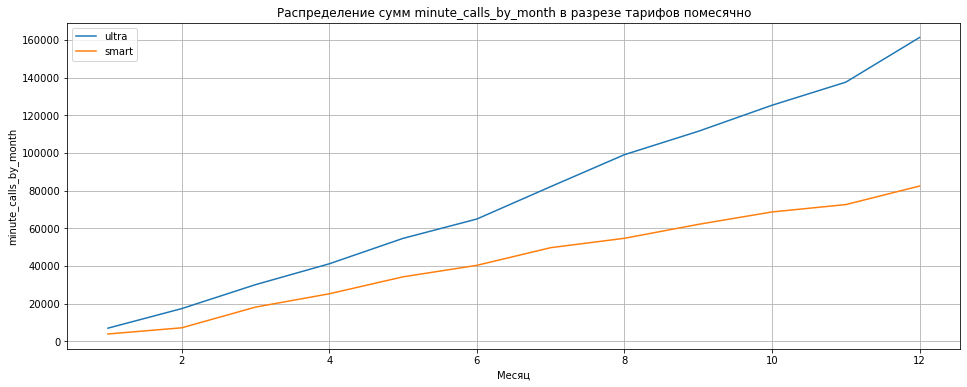

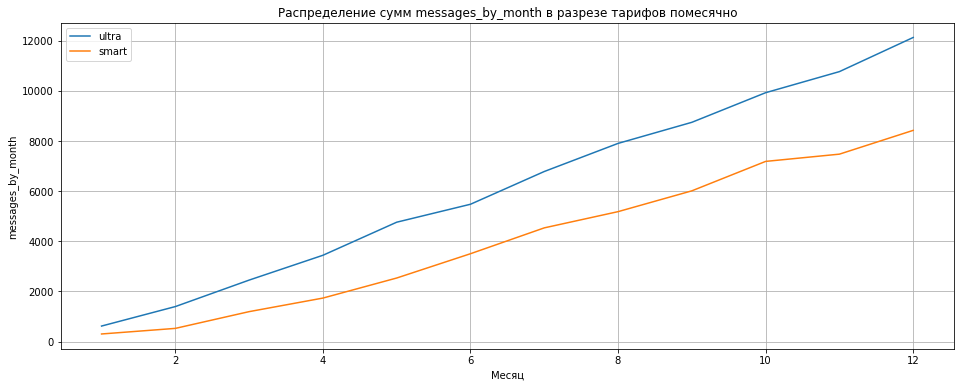

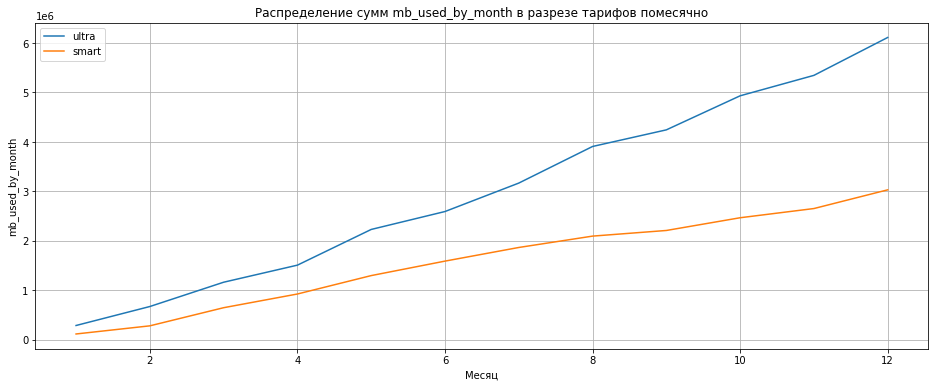

In [65]:
for columns in columns_:
    plt.figure(figsize=(16, 6), facecolor='w', edgecolor='k')
    smart_table[columns].plot()
    ultra_table[columns].plot()
    plt.title("Распределение сумм {} в разрезе тарифов помесячно".format(columns))
    plt.xlabel("Месяц")
    plt.ylabel(columns)
    plt.legend(["ultra", "smart"])
    plt.grid(True);

### Найдем среднее, дисперсию и стандартное отклонение для каждого из тарифов по минутам, смс, и интернет-трафику

In [66]:
statistic_new_data = (
                new_data
                        .pivot_table(index = 'tariff_name', 
                                    values = columns_, 
                                    aggfunc=[np.mean, np.std, np.var])
                        .reset_index().T
)
statistic_new_data

0            1
tariff_name                              smart        ultra
mean        mb_used_by_month           16229.2      19486.9
            messages_by_month           33.384      49.3635
            minute_calls_by_month      417.935      526.623
std         mb_used_by_month           5877.58      10096.3
            messages_by_month          28.2279      47.8045
            minute_calls_by_month      190.314      317.606
var         mb_used_by_month       3.45459e+07  1.01936e+08
            messages_by_month          796.813      2285.27
            minute_calls_by_month      36219.3       100874

In [67]:
# Создадим 2 датафрейма разделенным по тарифам ultra и smart
new_data_smart = new_data.query('tariff_name == "smart"')
new_data_ultra = new_data.query('tariff_name == "ultra"')

#### Посмотрим на графике данные по тарифу ultra

In [68]:
# ultra_pivot =     (
#         new_data_ultra
#             .pivot_table(index='month',
#                         values= 'mb_used_by_month',
#                         aggfunc= 'mean')
#             .plot(figsize=(12, 8), 
#                  grid=True, 
#                  style='o-')        
# )
# ultra_pivot

In [69]:
# smart_pivot =     (
#         new_data_ultra
#             .pivot_table(index='month',
#                         values= columns,
#                         aggfunc= 'mean')
#             .sns.lineplot(figsize=(12, 8), 
#                  grid=True, 
#                  style='o-')         
# )
# smart_pivot

In [70]:
# for columns in columns_:
#     (
#         new_data_smart
#             .pivot_table(index='month',
#                         values= columns,
#                         aggfunc= 'mean')
#             .plot(figsize=(12, 8), 
#                  grid=True, 
#                  style='o-')
            
# )
    
#     plt.title(f'Среднее {columns} распределенное по месяцам на тарифе smart')
#     plt.ylabel('Значения')
#     plt.xlabel('Месяц')
#     plt.show()


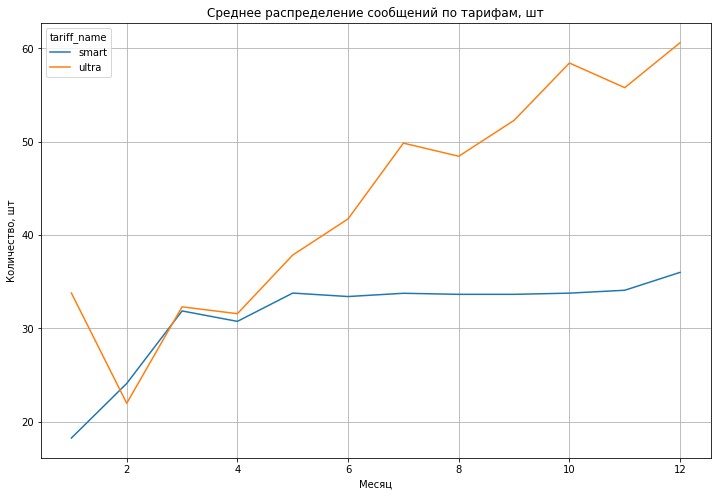

In [71]:
messages_by_month_compare = (new_data
            .pivot_table(index=['month', 'tariff_name'],
                        values= 'messages_by_month', 
                        aggfunc= 'mean')
             .reset_index()
             .set_index('month')
)
plt.figure(figsize=(12, 8))
sns.lineplot(x='month', y='messages_by_month', hue='tariff_name', data=messages_by_month_compare)
plt.title('Среднее распределение сообщений по тарифам, шт')
plt.ylabel('Количество, шт')
plt.xlabel('Месяц')
plt.grid(True);

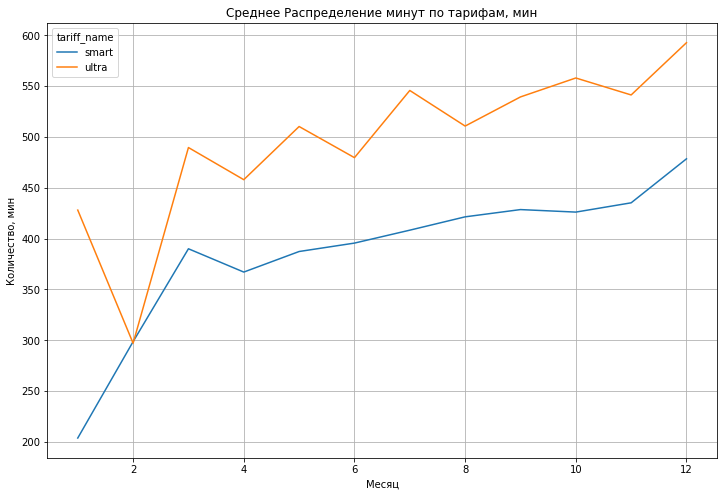

In [72]:
minute_calls_by_month_compare = (new_data
            .pivot_table(index=['month', 'tariff_name'],
                        values= 'minute_calls_by_month', 
                        aggfunc= 'mean')
             .reset_index()
             .set_index('month')
)
plt.figure(figsize=(12, 8))
sns.lineplot(x='month', y='minute_calls_by_month', hue='tariff_name', data=minute_calls_by_month_compare)
plt.title('Среднее Распределение минут по тарифам, мин')
plt.ylabel('Количество, мин')
plt.xlabel('Месяц')
plt.grid(True);

In [73]:
columns_

['minute_calls_by_month', 'messages_by_month', 'mb_used_by_month']

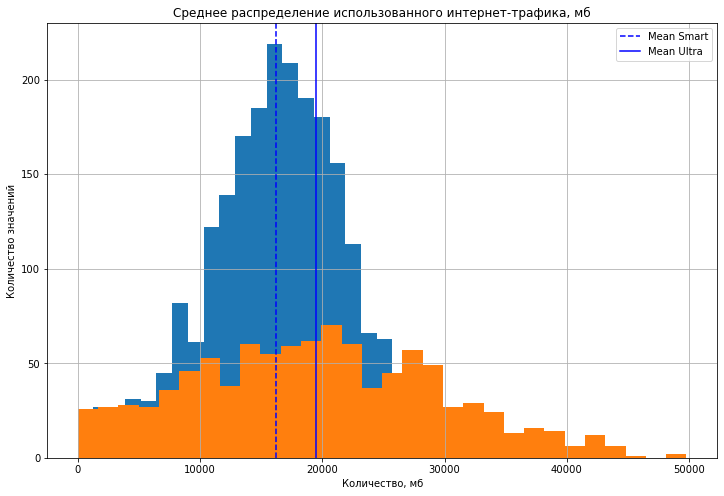

In [74]:
plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
new_data_smart['mb_used_by_month'].hist(bins=30, 
                                        range=(0, max(new_data_smart['mb_used_by_month'])))
new_data_ultra['mb_used_by_month'].hist(bins=30, 
                                        range=(0, max(new_data_ultra['mb_used_by_month'])))
plt.title('Среднее распределение использованного интернет-трафика, мб')
plt.xlabel('Количество, мб')
plt.ylabel('Количество значений')
plt.axvline(np.mean(new_data_smart['mb_used_by_month']),color='b', linestyle='dashed', label='Mean Smart')
plt.axvline(np.mean(new_data_ultra['mb_used_by_month']),color='b', linestyle='solid', label='Mean Ultra')
plt.legend()
plt.grid(True);

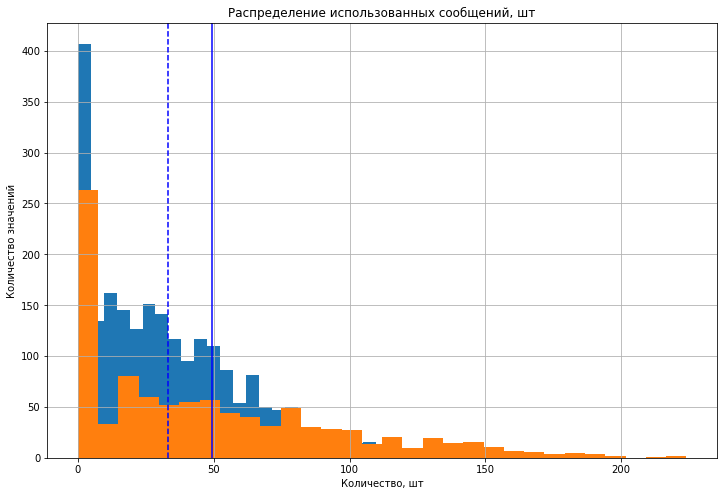

In [75]:
plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
new_data_smart['messages_by_month'].hist(bins=30, 
                                         range=(0, max(new_data_smart['messages_by_month'])))
new_data_ultra['messages_by_month'].hist(bins=30, 
                                         range=(0, max(new_data_ultra['messages_by_month'])))
plt.title('Распределение использованных сообщений, шт')
plt.xlabel('Количество, шт')
plt.ylabel('Количество значений')
plt.axvline(np.mean(new_data_smart['messages_by_month']),color='b', linestyle='dashed', label='Mean Smart')
plt.axvline(np.mean(new_data_ultra['messages_by_month']),color='b', linestyle='solid', label='Mean Ultra')
plt.grid(True);

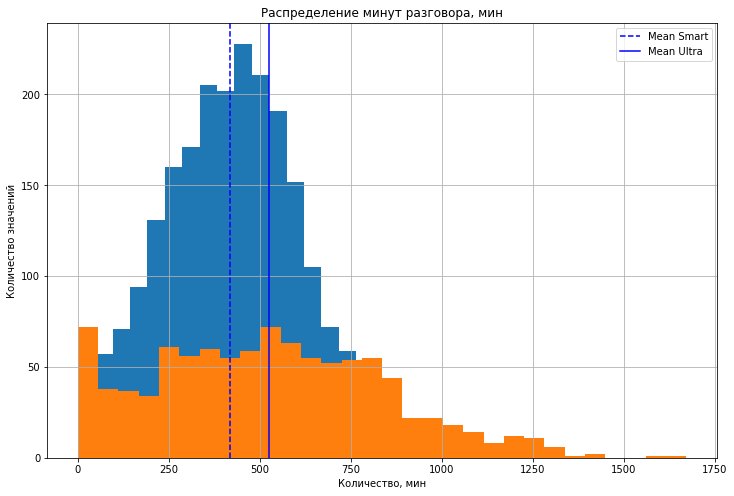

In [76]:
plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
new_data_smart['minute_calls_by_month'].hist(bins=30, 
                                             range=(0, max(new_data_smart['minute_calls_by_month'])))
new_data_ultra['minute_calls_by_month'].hist(bins=30, 
                                             range=(0, max(new_data_ultra['minute_calls_by_month'])))
plt.title('Распределение минут разговора, мин')
plt.xlabel('Количество, мин')
plt.ylabel('Количество значений')
plt.axvline(np.mean(new_data_smart['minute_calls_by_month']),color='b', linestyle='dashed', label='Mean Smart')
plt.axvline(np.mean(new_data_ultra['minute_calls_by_month']),color='b', linestyle='solid', label='Mean Ultra')
plt.legend()
plt.grid(True);

### Выводы:
    - Средние значения по израсходованным минутам,смс, интернету на тарифе smart ниже тех же показателей на тарифе ultra
    - Если средние значения по трафику отличаются не сильно в зависимости от тарифа (16гб - смарт, 19 - ультра), 
    то стандартное отклонение разниться практически в 2 раза (6000 и 10000 соответсвенно). Значит данные более изменчивы на данном тарифе.
    - По графикам тарифа смарт виден плавный рост потребления минут, смс, интернет трафика от месяца к месяцу. Наблюдается незначительный спад в 4 месяце
    - Пользователи, имеющие тариф ультра используют больше минут разговора, смс и интернет-трафика

### Проанализируем выручку по 2-м тарифам

In [77]:
new_data.head()

,user_id,month,calls_by_month,minute_calls_by_month,messages_by_month,mb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month_of_registration,profit
0,1000,5,22,159,22,2256,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
1,1000,6,43,172,60,23257,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
2,1000,7,47,340,75,14016,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
3,1000,8,52,408,81,14070,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
4,1000,9,58,466,57,14581,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0


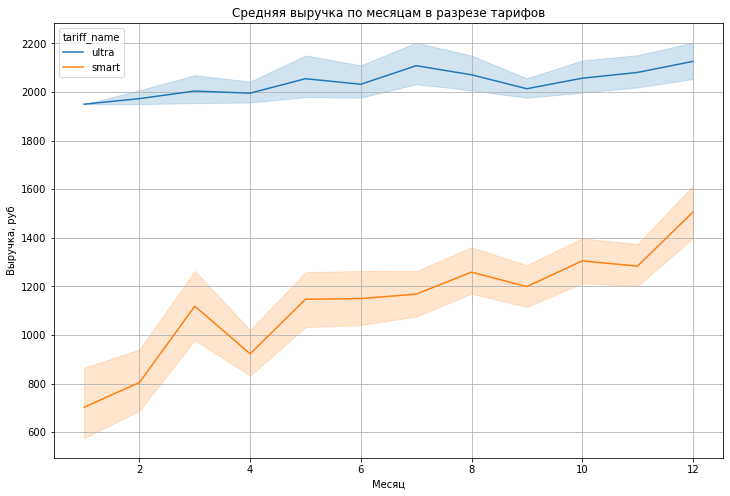

In [78]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='month', y='profit', hue='tariff_name', data=new_data)
plt.title('Средняя выручка по месяцам в разрезе тарифов')
plt.xlabel('Месяц')
plt.ylabel('Выручка, руб')
plt.grid(True);

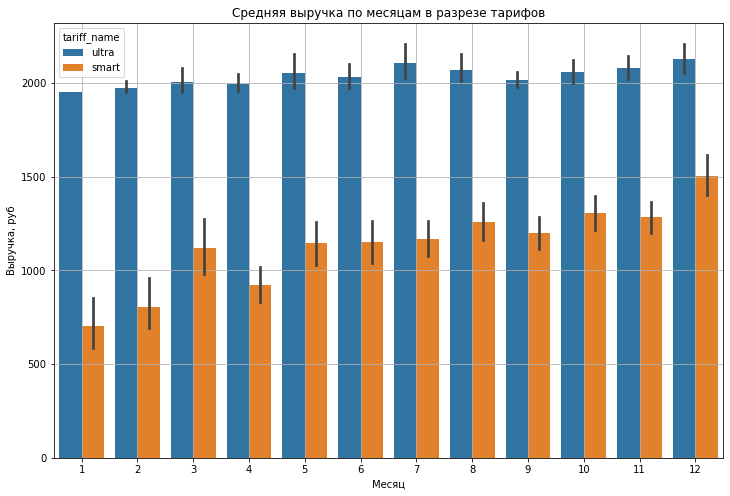

In [79]:
plt.figure(figsize=(12, 8))
sns.barplot(x="month", y="profit", hue="tariff_name", data=new_data)
plt.title('Средняя выручка по месяцам в разрезе тарифов')
plt.xlabel('Месяц')
plt.ylabel('Выручка, руб')
plt.grid(True);

### Рассчитаем итоговые значения

In [80]:
print('Количество клиентов тарифа Ultra: {}'.format(new_data_ultra['user_id'].nunique()))
print('Количество клиентов тарифа Smart: {}\n'.format(new_data_smart['user_id'].nunique()))
print('Средняя выручка c одного пользователя тарифа Ultra, рублей: {:.0f}'.format(new_data_ultra['profit'].sum() / new_data_ultra['user_id'].nunique()))
print('Средняя выручка c одного пользователя тарифа Smart, рублей: {:.0f}\n'.format(new_data_smart['profit'].sum() / new_data_smart['user_id'].nunique()))
print('Средняя годовая выручка по тарифу Ultra, рублей: {:.0f}'.format(new_data_ultra['profit'].sum()))
print('Средняя годовая выручка по тарифу Smart, рублей: {:.0f}\n'.format(new_data_smart['profit'].sum()))

Количество клиентов тарифа Ultra: 148
Количество клиентов тарифа Smart: 350

Средняя выручка c одного пользователя тарифа Ultra, рублей: 13714
Средняя выручка c одного пользователя тарифа Smart, рублей: 7855

Средняя годовая выручка по тарифу Ultra, рублей: 2029622
Средняя годовая выручка по тарифу Smart, рублей: 2749136



### Вывод:
    - Выручка на тарифе смарт выросла с 700 руб в первом месяце до 1500 руб в декабре.
    - При этом выручка по трифу ультра все равно значительно выше, даже учитывая то, что значительного роста не наблюдается
    - В апреле наблюжается просадка по выручке(обусловлена она снижением расхода звонков, смс и трафика)
    - Хотя и средняя выручка с одного пользователя тарифа ультра выше, но общая выручка по тарифу ниже за счет меньшего числа клиентов

# Проверим Гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

> Сформулируем нулевые гипотезы:

> - Нулевая гипотеза H₀: Средняя выручка пользователей тарифов Смарт и Ультра не различается
> - Альтернативная гипотеза H₁: Средняя выручка пользователей тарифов Смарт и Ультра различается

In [82]:
alpha = .05

In [124]:
new_data_smart_profit = new_data.query('tariff_name == "smart"')['profit']
new_data_smart_profit

8       1153.906250
9        550.000000
10       550.000000
11       987.695312
12      1524.023438
           ...     
3208     550.000000
3209     915.625000
3210    1375.781250
3211     971.093750
3212     936.914062
Name: profit, Length: 2229, dtype: float64

In [176]:
new_data_ultra_profit = new_data.query('tariff_name == "ultra"')['profit']
new_data_ultra_profit

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3204    1950.0
3205    1950.0
3206    1950.0
3207    1950.0
3213    1950.0
Name: profit, Length: 985, dtype: float64

*Единственный нюанс: тест Левена предполагает, что выборки ненормально распределены.*

> *Проверка выборок на нормальность. Тест Шапиро-Уилка позволяет проверить выборки на нормальность. И:*

>    *Если по результатам применения теста мы видим, что нормальность соблюдается, мы используем для проверки равенства (гомогенности) дисперсий тест Бартлета (проверка на равенство дисперсий двух нормально распределенных выборок)*

>    *В противном случае - тест Левена.*

*И затем уже мы устанавливаем значение параметра equal_var ttest_ind.*

#### Проверка гомогенности дисперсий двух сравниваемых выборок.

In [183]:
shapiro_test_smart_profit = st.shapiro(new_data_smart_profit)
shapiro_test_smart_profit
# p-value ниже 0.05, поэтому отклоняем нулевую гипотезу о нормальном распределении выборок.

ShapiroResult(statistic=0.8255404233932495, pvalue=4.90454462513686e-44)

In [174]:
shapiro_test_smart_profit.pvalue < alpha

True

p_value < 0.05, значит выборка распределена не нормально. Поэтому проводим тест Левена

In [172]:
st.levene(new_data_smart_profit, new_data_ultra_profit, center='mean')
# Исходя из теста Левена предполагаем что дисперсии неодинаковы, поэтому будем в критерии Стьюдента брать параметр equal_var = False

LeveneResult(statistic=656.5176825854346, pvalue=6.575293412962361e-132)

In [180]:
results = st.ttest_ind(new_data_smart_profit, new_data_ultra_profit, equal_var=False)

In [181]:
print('p_value:', results.pvalue)

p_value: 8.931402711368788e-296


In [182]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


> **Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;**

Сформулируем гипотезы :

> **- Нулевая гипотеза H₀: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов**  
> **- Альтернативная гипотеза H₁: Средняя выручка пользователей ииз Москвы отличается от выручки пользователей из других регионов**

In [134]:
# Приведем все названия городов к нижнему регистру, чтобы не потерять значения
new_data['city'] = new_data['city'].str.lower()

In [135]:
new_data_moscow_profit = new_data.query('city == "москва"')['profit']
new_data_moscow_profit

8       1153.906250
9        550.000000
17      1950.000000
18      1950.000000
19      1950.000000
           ...     
3119     550.000000
3120    1591.015625
3121    1208.789062
3122     637.109375
3213    1950.000000
Name: profit, Length: 611, dtype: float64

In [137]:
new_data_other_city_profit  = new_data.query('city != "москва"')['profit']
new_data_other_city_profit

0       1950.000000
1       1950.000000
2       1950.000000
3       1950.000000
4       1950.000000
           ...     
3208     550.000000
3209     915.625000
3210    1375.781250
3211     971.093750
3212     936.914062
Name: profit, Length: 2603, dtype: float64

#### Проверим, имеют ли выборки одинаковую дисперсию, для того, чтобы в дальнейшем более точно посчитать p_value

#### Проверка гомогенности дисперсий двух сравниваемых выборок.

####  Проведем тест  Шапиро-Уилка, чтобы проверить выборки на нормальность.

In [184]:
shapiro_test_moscow = st.shapiro(new_data_other_city_profit)
shapiro_test_moscow
# p-value ниже 0.05, поэтому отклоняем нулевую гипотезу о нормальном распределении выброк.

ShapiroResult(statistic=0.8875685334205627, pvalue=5.8070088621313284e-40)

In [185]:
shapiro_test_other_city = st.shapiro(new_data_moscow_profit)
shapiro_test_other_city
# p-value ниже 0.05, поэтому отклоняем нулевую гипотезу о нормальном распределении выброк.

ShapiroResult(statistic=0.8941619396209717, pvalue=4.375855880004554e-20)

#### Проводим тест Левена

In [190]:
st.levene(new_data_moscow_profit, new_data_other_city_profit, center='mean')
# Исходя из теста Левена предполагаем что дисперсии одинаковы, поэтому будем в критерии Стьюдента брать параметр equal_var = True

LeveneResult(statistic=3.5667101508047576, pvalue=0.059039017535414746)

In [140]:
new_data_moscow_profit.var()

547242.7498927516

In [141]:
new_data_other_city_profit.var()

630503.8546346669

In [152]:
alpha = .05

In [191]:
results = st.ttest_ind(new_data_moscow_profit, new_data_other_city_profit, equal_var = True)

In [192]:
print('p_value:', results.pvalue)

p_value: 0.47443187631524797


In [193]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


In [196]:
print('Средняя выручка пользователей тарифа smart:', new_data_smart['profit'].mean())
print('Средняя выручка пользователей тарифа ultra:', new_data_ultra['profit'].mean())

Средняя выручка пользователей тарифа smart: 1233.3494665489009
Средняя выручка пользователей тарифа ultra: 2060.5299710501267


# Вывод:
    
    - Сформулировали нулевые и альтернативные гипотезы. В качестве нулевой гипотезы взяли отрицательное предположение ( не различается, не отличается)
    - С помощью критерия Стьюдента проверили нулевую гипотезу. Получили следующие результаты: 
    1. Средняя выручка пользователей тарифов Смарт и Ультра различается
    2. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

# Общий вывод:
    1. Целью этого исследования было выяснить, какой из двух тарифов - smart или ultra приносит больше денег компании. Были изучены данные на аномальные значения, выявлены пропуски в данных.  
    
    2. Некоторые значения были округлены согласно условиям задачи, были изменены типы некоторых колонок для более удобного анализа данных.  
    
    3. Добавили дополнительный признак "Месяц" для анализа выручки помесячно.
    
    4. Разбили данные на два датасета по трифам.  
    
    5. Выполнили анализ данных. В ходе которого выявили: 
    
        
        5.1 Выручка по тарифу "Смарт" выросла за год более чем в два раза - с 700 рублей в месяц до 1600 рублей в месяц, выручка по тарифу "Ультра" такжее немного выросла и - с 1950 рублей в месяц до 2100 рублей в месяц. При этом тариф "Ультра" приносит больше денег, чем тариф "Смарт".
        
       
       5.2 Анализ по клиентам тарифа "Смарт"(средние значения):

            5.2.1 ~ 420 минут в месяц; ~ 66% укладывются в лимит 500 минут, включенных в тариф, ~ 34% - перерасходуют;

            5.2.2 ~ 35 смс в месяц; ~ 74% клиентов не превышают лимит 50 смс, включенных в пакет, ~ 16% - перерасходуют;

            5.2.3 ~ 16 Гб в месяц, Только ~ 41% клиентов не перерасходуют интернет-трафик;

        5.3 Анализ по клиентам тарифа "Ультра"(средние значения):

            5.3.1 ~ 530 минут в месяц; Нет клиентов расходующих минуты сверхлимита 3000 минут;

            5.3.2 ~ 50 смс в месяц; Нет клиентов расходующих собщения сверхлимита 1000 смс;

            5.3.3 ~ 20 Гб в месяц, ~ 14% клиентов перерасходуют лимит интернет-трафика 30 Гб включенных в тариф.

        5.4 Средняя выручка пользователей тарифа smart: 1233 руб
        
        5.5 Средняя выручка пользователей тарифа ultra: 2060 руб

Исходя из этого можно сделать вывод, что поведение пользователей тарифов не сильно отличаются друг от друга. Вероятно более высокая среднняя выручка связана с  более высокой абонентской платой.


    
        

    

In [247]:
smart_limit_minutes = new_data_smart.query('minute_calls_by_month > @smart_minutes_included')['user_id'].count() / len(new_data_smart)
smart_limit_minutes

0.3382682817406909

In [248]:
smart_limit_messages = new_data_smart.query('messages_by_month > @smart_messages_included')['user_id'].count() / len(new_data_smart)
smart_limit_messages

0.253028263795424

In [249]:
smart_limit_mb = new_data_smart.query('mb_used_by_month > @smart_mb_per_month_included')['user_id'].count() / len(new_data_smart)
smart_limit_mb

0.5872588604755495

In [250]:
ultra_limit_minutes = new_data_ultra.query('minute_calls_by_month > @ultra_minutes_included')['user_id'].count() / len(new_data_ultra)
ultra_limit_minutes

0.0

In [251]:
ultra_limit_messages = new_data_ultra.query('messages_by_month > @ultra_messages_included')['user_id'].count() / len(new_data_ultra)
ultra_limit_messages

0.0

In [252]:
ultra_limit_mb = new_data_ultra.query('mb_used_by_month > @ultra_mb_per_month_included')['user_id'].count() / len(new_data_ultra)
ultra_limit_mb

0.13604060913705585